In [1]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
from scipy.stats import gmean
import cv2
import matplotlib.pyplot as plt

# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [2]:
image= "/home/casper/Documents/Aardwetenschappen/MSc Thesis/Photo/08_07_22/Location_2/Loc_2_3.jpg"
resolution = 0.0328590785907859
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)
maxscale= width*resolution / 8

x= 0
verbose = 1

im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

filter=False

if filter:
    sigma_est = estimate_sigma(im, multichannel=False, average_sigmas=True)
    region = denoise_wavelet(im, multichannel=False, rescale_sigma=True,
                                method='VisuShrink', mode='soft', sigma=sigma_est*2)
else:
    region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape


In [3]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 0.1), np.maximum(nx,ny)/(width*resolution / 12), 1),  'morl', .5) #cmor10-1.9
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_3 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_3-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_3, np.mean(M), srt/2)
p = np.hstack([p])
scales_3 = np.hstack([scales_3])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_3 = (p*scales_3**x) / np.sum(p*scales_3**x) #volume-by-weight proportion



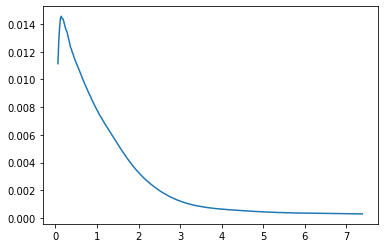

In [4]:
plt.plot((scales_3*resolution), r_v_3)
plt.show()


In [5]:
print(np.trapz(r_v_3,(scales_3)))
print(np.trapz(r_v_3))

0.611867197772619
0.9942841963805055


0.6169362262391971


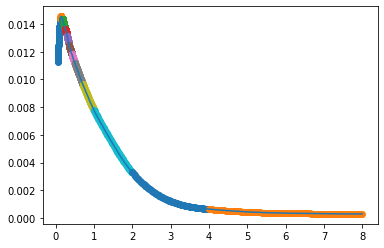

In [6]:
x1 = (np.interp([np.linspace(0.063, 0.125, 100)], (scales_3*resolution), r_v_3)[0])

x2 = (np.interp([np.linspace(0.125, 0.180, 100)], (scales_3*resolution), r_v_3)[0])

x3 = (np.interp([np.linspace(0.180, 0.250, 100)], (scales_3*resolution), r_v_3)[0])

x4 = (np.interp([np.linspace(0.250, 0.300, 100)], (scales_3*resolution), r_v_3)[0])

x5 = (np.interp([np.linspace(0.300, 0.355, 100)], (scales_3*resolution), r_v_3)[0])

x6 = (np.interp([np.linspace(0.355, 0.425, 100)], (scales_3*resolution), r_v_3)[0])

x7 = (np.interp([np.linspace(0.425, 0.500, 100)], (scales_3*resolution), r_v_3)[0])

x8 = (np.interp([np.linspace(0.500, 0.710, 100)], (scales_3*resolution), r_v_3)[0])

x9 = (np.interp([np.linspace(0.710, 1, 100)], (scales_3*resolution), r_v_3)[0])

x10 = (np.interp([np.linspace(1, 2, 100)], (scales_3*resolution), r_v_3)[0])

x11 = (np.interp([np.linspace(2, 4, 100)], (scales_3*resolution), r_v_3)[0])

x12 = (np.interp([np.linspace(4, 8, 100)], (scales_3*resolution), r_v_3)[0])

ytot = np.concatenate((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12))
xtot = np.concatenate((np.linspace(0.063, 0.125, 100), np.linspace(0.125, 0.180, 100), np.linspace(0.180, 0.250, 100), np.linspace(0.250, 0.300, 100),
                       np.linspace(0.300, 0.355, 100), np.linspace(0.355, 0.425, 100), np.linspace(0.425, 0.500, 100), np.linspace(0.500, 0.710, 100),
                       np.linspace(0.710, 1, 100), np.linspace(1, 2, 100), np.linspace(2, 4, 100), np.linspace(4, 8, 100)))
print(np.trapz(ytot, xtot)/resolution)
plt.scatter(np.linspace(0.063, 0.125, 100), x1)
plt.scatter(np.linspace(0.125, 0.180, 100), x2)
plt.scatter(np.linspace(0.180, 0.250, 100), x3)
plt.scatter(np.linspace(0.250, 0.300, 100), x4)
plt.scatter(np.linspace(0.300, 0.355, 100), x5)
plt.scatter(np.linspace(0.355, 0.425, 100), x6)
plt.scatter(np.linspace(0.425, 0.500, 100), x7)
plt.scatter(np.linspace(0.500, 0.710, 100), x8)
plt.scatter(np.linspace(0.710, 1, 100), x9)
plt.scatter(np.linspace(1, 2, 100), x10)
plt.scatter(np.linspace(2, 4, 100), x11)
plt.scatter(np.linspace(4, 8, 100), x12)
plt.plot(xtot, ytot)
plt.show()

In [7]:
z = np.polyfit(np.linspace(0.063, 0.125, 100), np.interp([np.linspace(0.063, 0.125, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
func = np.poly1d(z)
z = np.polyfit(np.linspace(0.125, 0.180, 100), np.interp([np.linspace(0.125, 0.180, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.180, 0.250, 100), np.interp([np.linspace(0.180, 0.250, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.250, 0.300, 100), np.interp([np.linspace(0.250, 0.300, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.300, 0.355, 100), np.interp([np.linspace(0.300, 0.355, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.355, 0.425, 100), np.interp([np.linspace(0.355, 0.425, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.425, 0.500, 100), np.interp([np.linspace(0.425, 0.500, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.500, 0.710, 100), np.interp([np.linspace(0.500, 0.710, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(0.710, 1, 100), np.interp([np.linspace(0.710, 1, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(1, 2, 100), np.interp([np.linspace(1, 2, 100)], (scales_3*resolution), r_v_3)[0],5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(2, 4, 100), np.interp([np.linspace(2, 4, 100)], (scales_3*resolution), r_v_3)[0], 5)
print(np.poly1d(z))
z = np.polyfit(np.linspace(4, 8, 1000), np.interp([np.linspace(4, 8, 1000)], (scales_3*resolution), r_v_3)[0], 2)
print(np.poly1d(z))


           2
2.839e-05 x - 0.0004175 x + 0.001833


In [33]:
a = (scales_3*resolution)
minSz = np.array([0, 0.063, 0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8])
maxSz = np.array([0.063, 0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8, 12])

for i in range(len(minSz)):
    _, length = np.shape(np.where((a>minSz[i])&(a<maxSz[i])))
    print(np.trapz(np.interp([np.linspace(minSz[i], maxSz[i], 1000)], (scales_3*resolution), r_v_3)[0])*length/1000)

0.011126242832438014
0.03951831953841176
0.02886964700282796
0.05604288328216678
0.026855729658201065
0.03840860782487487
0.03633746633943586
0.045960175326985944
0.11450785699741374
0.12171025707899388
0.26373898745636654
0.14520200203606848
0.06518406847948749
0.0
